In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

import torch
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

from relu_nn.relu_nn import FFReLUNet

In [2]:
# helper functions
def to_np(x):
    return x.detach().numpy()

In [15]:
# Setup the mp-LP
x_dim, y_dim, ncon = 1, 1, 10

_c = cp.Parameter(y_dim)
_A = cp.Parameter((ncon, y_dim))
_b = cp.Parameter(ncon)
_S = cp.Parameter((ncon, x_dim))
_x = cp.Parameter(x_dim)
_xp = cp.Variable(x_dim)
_y = cp.Variable(y_dim)

obj = cp.Minimize(_c @ _y)
cons = [_A @ _y - _S @ _xp <= _b, _xp == _x, _y <= 1, -_y <= 1]
prob = cp.Problem(obj, cons)

layer = CvxpyLayer(prob, parameters=[_c, _A, _b, _S, _x], variables=[_xp, _y])

# Initialize parameters
torch.manual_seed(6)
c = torch.rand(y_dim, requires_grad=True)
A = torch.rand(ncon, y_dim, requires_grad=True)
b = torch.rand(ncon, requires_grad=True)
S = torch.rand(ncon, x_dim, requires_grad=True)

In [16]:
# Setup the model
shape = [1, 8, 8, 1]
model = FFReLUNet(shape)
loss_fn = torch.nn.MSELoss()

# Setup the optimizer
lr = 1e-3
num_iters = 1000
opt = torch.optim.Adam(model.parameters(), lr)

# Setup the data
x_min, x_max = -np.pi, np.pi
pha = 3.0
frq = 2.2
amp = 0.5 

num_train = 15000
num_test = 5000

X_train = (x_max - x_min) * torch.randn(num_train) + x_min
print(X_train.size())
Y_train = amp * torch.sin(frq * X_train + pha)
X_train = X_train.reshape(-1, 1)
Y_train = Y_train.reshape(-1, 1)

print(X_train.size())

# Train the NN model
print("Training NN:")
training_losses = np.zeros((num_iters))
for it in range(num_iters):
    opt.zero_grad()

    Yh = model.forward(X_train)
    
    loss = loss_fn(Y_train, Yh)
    loss.backward()
    training_losses[it] = loss.data.numpy()
    opt.step()
    
    if it % 50 == 0:
        print(it, "/", num_iters, loss)

        
# Train the mp-LP model
print("\nTraining LP")
training_losses = np.zeros((num_iters))
for it in range(num_iters):
    opt.zero_grad()

    Yh = layer(c, A, b, S, X_train)
    
    loss = loss_fn(Y_train, Yh)
    loss.backward()
    training_losses[it] = loss.data.numpy()
    opt.step()
    
    if it % 50 == 0:
        print(it, "/", num_iters, loss)

torch.Size([15000])
torch.Size([15000, 1])
Training NN:
0 / 1000 tensor(0.1600, grad_fn=<MseLossBackward>)
50 / 1000 tensor(0.1335, grad_fn=<MseLossBackward>)
100 / 1000 tensor(0.1261, grad_fn=<MseLossBackward>)
150 / 1000 tensor(0.1228, grad_fn=<MseLossBackward>)
200 / 1000 tensor(0.1207, grad_fn=<MseLossBackward>)
250 / 1000 tensor(0.1187, grad_fn=<MseLossBackward>)
300 / 1000 tensor(0.1160, grad_fn=<MseLossBackward>)
350 / 1000 tensor(0.1131, grad_fn=<MseLossBackward>)
400 / 1000 tensor(0.1102, grad_fn=<MseLossBackward>)
450 / 1000 tensor(0.1076, grad_fn=<MseLossBackward>)
500 / 1000 tensor(0.1053, grad_fn=<MseLossBackward>)
550 / 1000 tensor(0.1036, grad_fn=<MseLossBackward>)
600 / 1000 tensor(0.1022, grad_fn=<MseLossBackward>)
650 / 1000 tensor(0.1011, grad_fn=<MseLossBackward>)
700 / 1000 tensor(0.1004, grad_fn=<MseLossBackward>)
750 / 1000 tensor(0.0999, grad_fn=<MseLossBackward>)
800 / 1000 tensor(0.0995, grad_fn=<MseLossBackward>)
850 / 1000 tensor(0.0991, grad_fn=<MseLossBack

SolverError: Solver scs returned status Infeasible

/home/joe/para_prog_learning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


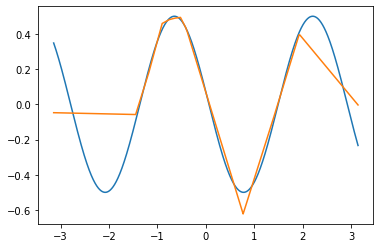

In [10]:
X_test = torch.linspace(x_min, x_max, num_train)
Y_test = amp * torch.sin(frq * X_test + pha)
X_test = X_test.reshape(-1, 1, 1)
Y_test = Y_test.reshape(-1, 1, 1)

Y_pred = model.forward(X_test)

fig = plt.figure()
plt.plot(X_test.numpy().flatten(), Y_test.numpy().flatten())
plt.plot(X_test.numpy().flatten(), Y_pred.detach().numpy().flatten())

fig.show()